# Movie Reccomendation ELT Pipeline
In this project, I will be creating an ELT pipeline that extracts publicly available movie data from IMDb into a dataset, transforms this dataset into clean, analysis-ready form, and then performs analysis on it in order to gain insight on the movie data. 

# Extracting and Loading the Data: 

In [29]:
# Make necessary imports
from bs4 import BeautifulSoup
import requests 
import matplotlib.pyplot as plt

# Get page through BeautifulSoup4
imDb_url = 'https://www.imdb.com/chart/top/?ref_=nv_mv_250'
imDb_html = requests.get(imDb_url).text
imDb = BeautifulSoup(imDb_html, 'lxml')

In [30]:
# We are going to create lists for some information about each movie. 
# Then, we will scrape through each movie in the top 250 and append the information to the lists in scraped order
# We will also create hashsets that contain the URLS for the rating and main pages so we can easily access this info later 
titles = []
ids = []
years = []
imDb_ratings_urls = {}
imDb_main_urls = {}
movies = imDb.find_all('td', class_ = 'titleColumn')
for movie in movies: 
    title = movie.find('a').text
    titles.append(title)
    year = movie.find('span').text
    year = year[1:-1] # Removing the parentheses
    years.append(year)
    href = movie.find('a').get('href') # href is in the form /title/tt0111161/ or /title/tt0111161x/
    id = 0
    if(len(href) == 17): 
        id = href[-10:-1]
    if(len(href) == 18): 
        id = href[-11:-1]
    ids.append(id)
    rating_url = 'https://www.imdb.com/title/' + id + '/ratings/?ref_=tt_ov_rt'
    imDb_ratings_urls[title] = rating_url
    main_url = 'https://www.imdb.com' + href + '?pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=1a264172-ae11-42e4-8ef7-7fed1973bb8f&pf_rd_r=GPQ6TD04N1JRGFMQMSXW&pf_rd_s=center-1&pf_rd_t=15506&pf_rd_i=top&ref_=chttp_tt'
    imDb_main_urls[title] = main_url

In [31]:
# Lets start creating the dataframe to be used 
import pandas as pd
import numpy as np
movie_data = pd.DataFrame()
movie_data['Title'] = titles
movie_data['ID'] = ids
movie_data['Year'] = years

# We now have the start of our dataframe which is simply the movie title, ID,, year produced, and OVR rating 
# In this dataframe, the ID will be the PK since it must be unique for each movie
movie_data

,Title,ID,Year
0,The Shawshank Redemption,tt0111161,1994
1,The Godfather,tt0068646,1972
2,The Dark Knight,tt0468569,2008
3,The Godfather Part II,tt0071562,1974
4,12 Angry Men,tt0050083,1957
...,...,...,...
245,Gandhi,tt0083987,1982
246,Aladdin,tt0103639,1992
247,The Help,tt1454029,2011
248,Jai Bhim,tt15097216,2021


In [32]:
# Let's scrape the main pages for each movie to generate more info such as Director, Genre, Star, etc. 
# Create arrays to contain the information in scraped order 
genre1s = []
genre2s = []
genre3s = []
directors = []
primary_stars = []
secondary_stars = []
tertiary_stars = []
for movie in titles: 
    main_url = imDb_main_urls[movie]
    main_html = requests.get(main_url).text 
    main = BeautifulSoup(main_html, 'lxml')
    genres = main.find_all('a', class_ = 'sc-16ede01-3 bYNgQ ipc-chip ipc-chip--on-baseAlt')
    genre1 = genres[0].span.text
    genre1s.append(genre1)
    genre2 = 'None'
    if(len(genres) > 1): 
        genre2 = genres[1].span.text 
    genre2s.append(genre2)  
    genre3 = 'None'
    if(len(genres) > 2): 
        genre3 = genres[2].span.text
    genre3s.append(genre3)
    credits = main.find_all('li', attrs={"data-testid":"title-pc-principal-credit"})
    credits = credits[3:6]
    director_tag = credits[0]
    stars_tag = credits[2]
    director = director_tag.find('a', class_ = 'ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link').text
    directors.append(director)
    stars = stars_tag.find_all('li', class_ = 'ipc-inline-list__item')
    primary_star = stars[0].a.text
    primary_stars.append(primary_star)
    secondary_star = 'None'
    if(len(stars) > 1): 
        secondary_star = stars[1].a.text
    secondary_stars.append(secondary_star)
    tertiary_star = 'None'
    if(len(stars) > 2): 
        tertiary_star = stars[2].a.text
    tertiary_stars.append(tertiary_star)

In [33]:
# Add this new information to the dataframe
movie_data['Primary_Genre'] = genre1s
movie_data['Secondary_Genre'] = genre2s
movie_data['Tertiary_Genre'] = genre3s
movie_data['Director'] = directors
movie_data['Primary_Star'] = primary_stars
movie_data['Secondary_Star'] = secondary_stars
movie_data['Tertiary_Star'] = tertiary_stars 

movie_data

,Title,ID,Year,Primary_Genre,Secondary_Genre,Tertiary_Genre,Director,Primary_Star,Secondary_Star,Tertiary_Star
0,The Shawshank Redemption,tt0111161,1994,Drama,None,None,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton
1,The Godfather,tt0068646,1972,Crime,Drama,None,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan
2,The Dark Knight,tt0468569,2008,Action,Crime,Drama,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart
3,The Godfather Part II,tt0071562,1974,Crime,Drama,None,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall
4,12 Angry Men,tt0050083,1957,Crime,Drama,None,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam
...,...,...,...,...,...,...,...,...,...,...
245,Gandhi,tt0083987,1982,Biography,Drama,None,Richard Attenborough,Ben Kingsley,John Gielgud,Rohini Hattangadi
246,Aladdin,tt0103639,1992,Animation,Adventure,Comedy,Ron Clements,Scott Weinger,Robin Williams,Linda Larkin
247,The Help,tt1454029,2011,Drama,None,None,Tate Taylor,Emma Stone,Viola Davis,Octavia Spencer
248,Jai Bhim,tt15097216,2021,Crime,Drama,Mystery,T.J. Gnanavel,Suriya,Lijo Mol Jose,Manikandan K.


In [34]:
# Now let's scrape the ratings pages to generate more rating info
all_alls = []
all_0to17s = [] 
all_18to29s = [] 
all_30to44s = []
all_45ups = []
male_alls = []
male_0to17s = []
male_18to29s = []
male_30to44s = []
male_45ups = []
female_alls = []
female_0to17s = []
female_18to29s = []
female_30to44s = []
female_45ups = []
other_tops = []
other_USs = []
other_nonUSs = []

for movie in titles: 
    
    ratings_url = imDb_ratings_urls[movie]
    ratings_html = requests.get(ratings_url).text 
    ratings = BeautifulSoup(ratings_html, 'lxml')
    master_ratings = ratings.find_all('tr', height = '70')
    all_ratings = master_ratings[0].find_all('td', align = 'center')
    male_ratings = master_ratings[1].find_all('td', align = 'center')
    female_ratings = master_ratings[2].find_all('td', align = 'center')
    other_ratings = master_ratings[3].find_all('td', align = 'center')
    all_all = all_ratings[0].div.text
    all_alls.append(all_all)
    all_0to17 = all_ratings[1].div.text
    all_0to17s.append(all_0to17)
    all_18to29 = all_ratings[2].div.text
    all_18to29s.append(all_18to29)
    all_30to44 = all_ratings[3].div.text
    all_30to44s.append(all_30to44)
    all_45up = all_ratings[4].div.text
    all_45ups.append(all_45up)
    male_all = male_ratings[0].div.text
    male_alls.append(male_all)
    male_0to17 = male_ratings[1].div.text
    male_0to17s.append(male_0to17)
    male_18to29 = male_ratings[2].div.text
    male_18to29s.append(male_18to29)
    male_30to44 = male_ratings[3].div.text
    male_30to44s.append(male_30to44)
    male_45up = male_ratings[4].div.text
    male_45ups.append(male_45up)
    female_all = female_ratings[0].div.text
    female_alls.append(female_all)
    female_0to17 = female_ratings[1].div.text
    female_0to17s.append(female_0to17)
    female_18to29 = female_ratings[2].div.text
    female_18to29s.append(female_18to29)
    female_30to44 = female_ratings[3].div.text
    female_30to44s.append(female_30to44)
    female_45up = female_ratings[4].div.text
    female_45ups.append(female_45up)
    other_top = other_ratings[0].div.text
    other_tops.append(other_top)
    other_US = other_ratings[1].div.text
    other_USs.append(other_US)
    other_nonUS = other_ratings[2].div.text
    other_nonUSs.append(other_nonUS)

In [35]:
# Lets add this newly found rating data to the dataframe 
movie_data['All_All_Rating'] = all_alls
movie_data['All_0-17_Rating'] = all_0to17s
movie_data['All_18-29_Rating'] = all_18to29s
movie_data['All_30-44_Rating'] = all_30to44s
movie_data['All_45+_Rating'] = all_45ups
movie_data['Male_All_Rating'] = male_alls
movie_data['Male_0-17_Rating'] = male_0to17s
movie_data['Male_18-29_Rating'] = male_18to29s
movie_data['Male_30-44_Rating'] = male_30to44s
movie_data['Male_45+_Rating'] = male_45ups
movie_data['Female_All_Rating'] = female_alls
movie_data['Female_0-17_Rating'] = female_0to17s
movie_data['Female_18-29_Rating'] = female_18to29s
movie_data['Female_30-44_Rating'] = female_30to44s
movie_data['Female_45+_Rating'] = female_45ups
movie_data['Top1000_Rating'] = other_tops
movie_data['USUsers_Rating'] = other_USs
movie_data['NonUSUsers_Rating'] = other_nonUSs

movie_data

,Title,ID,Year,Primary_Genre,Secondary_Genre,Tertiary_Genre,Director,Primary_Star,Secondary_Star,Tertiary_Star,...,Male_30-44_Rating,Male_45+_Rating,Female_All_Rating,Female_0-17_Rating,Female_18-29_Rating,Female_30-44_Rating,Female_45+_Rating,Top1000_Rating,USUsers_Rating,NonUSUsers_Rating
0,The Shawshank Redemption,tt0111161,1994,Drama,None,None,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,...,9.3,9.1,9.2,9.0,9.3,9.2,9.2,8.9,9.3,9.2
1,The Godfather,tt0068646,1972,Crime,Drama,None,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,...,9.2,9.2,8.9,9.0,8.9,8.9,9.0,9.1,9.2,9.2
2,The Dark Knight,tt0468569,2008,Action,Crime,Drama,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,...,9.1,8.4,8.7,8.6,8.9,8.7,8.2,8.6,9.1,8.9
3,The Godfather Part II,tt0071562,1974,Crime,Drama,None,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,...,9.0,9.0,8.8,8.6,8.8,8.7,8.8,8.8,9.1,9.0
4,12 Angry Men,tt0050083,1957,Crime,Drama,None,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,...,9.0,8.8,8.9,8.9,9.0,8.9,8.8,8.7,8.9,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,Gandhi,tt0083987,1982,Biography,Drama,None,Richard Attenborough,Ben Kingsley,John Gielgud,Rohini Hattangadi,...,8.1,8.1,8.0,6.9,7.8,8.0,8.2,7.7,8.1,8.0
246,Aladdin,tt0103639,1992,Animation,Adventure,Comedy,Ron Clements,Scott Weinger,Robin Williams,Linda Larkin,...,8.0,7.7,8.2,7.5,8.1,8.3,8.0,7.7,8.2,7.9
247,The Help,tt1454029,2011,Drama,None,None,Tate Taylor,Emma Stone,Viola Davis,Octavia Spencer,...,7.9,7.9,8.4,7.1,8.5,8.4,8.4,7.4,8.0,8.0
248,Jai Bhim,tt15097216,2021,Crime,Drama,Mystery,T.J. Gnanavel,Suriya,Lijo Mol Jose,Manikandan K.,...,8.2,6.5,7.6,2.7,8.0,7.6,5.9,4.6,7.7,8.0


# Transforming the Data: 
Now that we have gathered all the data we need for our analysis, we need to make sure that it is in a tidy format. 

First, our data contains columns that are values. For example, Male 30-44 Rating contains both the gender of the reviewees and their age group. Instead, we should have a column labeled Gender and a column labeled Age and then a column with the rating. To do this we need to melt our data down and elongate it vertically.  

In [36]:
# Let's use the melt function to get the gender and age into their own columns
movie_data_melt1 = pd.melt(
    movie_data,
    id_vars = ['Title', 'ID', 'Year', 'Primary_Genre', 'Secondary_Genre', 'Tertiary_Genre', 'Director', 'Primary_Star', 'Secondary_Star', 'Tertiary_Star'], 
    var_name = 'GroupTemp',
    value_name = 'Rating'
)

In [37]:
movie_data_melt1

,Title,ID,Year,Primary_Genre,Secondary_Genre,Tertiary_Genre,Director,Primary_Star,Secondary_Star,Tertiary_Star,GroupTemp,Rating
0,The Shawshank Redemption,tt0111161,1994,Drama,None,None,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,All_All_Rating,9.3
1,The Godfather,tt0068646,1972,Crime,Drama,None,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,All_All_Rating,9.2
2,The Dark Knight,tt0468569,2008,Action,Crime,Drama,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,All_All_Rating,9.0
3,The Godfather Part II,tt0071562,1974,Crime,Drama,None,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,All_All_Rating,9.0
4,12 Angry Men,tt0050083,1957,Crime,Drama,None,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,All_All_Rating,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4495,Gandhi,tt0083987,1982,Biography,Drama,None,Richard Attenborough,Ben Kingsley,John Gielgud,Rohini Hattangadi,NonUSUsers_Rating,8.0
4496,Aladdin,tt0103639,1992,Animation,Adventure,Comedy,Ron Clements,Scott Weinger,Robin Williams,Linda Larkin,NonUSUsers_Rating,7.9
4497,The Help,tt1454029,2011,Drama,None,None,Tate Taylor,Emma Stone,Viola Davis,Octavia Spencer,NonUSUsers_Rating,8.0
4498,Jai Bhim,tt15097216,2021,Crime,Drama,Mystery,T.J. Gnanavel,Suriya,Lijo Mol Jose,Manikandan K.,NonUSUsers_Rating,8.0


In [38]:
# This is better than before, however the group column still contains two values in each row 
# (Age and Gender or US/NonUS). We need to capture these values and separate them into the smallest possible data
age_gender = list(movie_data_melt1['GroupTemp'])
ages = []
groups = []
for val in age_gender: 
    info = val.split('_')
    age = 'NA'
    group = 'NA'
    if(len(info) == 3): 
        group = info[0]
        age = info[1]
    else: 
        group = info[0]
    ages.append(age)
    groups.append(group)
movie_data_melt1['Group'] = groups
movie_data_melt1['Age'] = ages
movie_data_melt1.drop('GroupTemp', axis = 1, inplace = True)
movie_data_melt1

,Title,ID,Year,Primary_Genre,Secondary_Genre,Tertiary_Genre,Director,Primary_Star,Secondary_Star,Tertiary_Star,Rating,Group,Age
0,The Shawshank Redemption,tt0111161,1994,Drama,None,None,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,9.3,All,All
1,The Godfather,tt0068646,1972,Crime,Drama,None,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,9.2,All,All
2,The Dark Knight,tt0468569,2008,Action,Crime,Drama,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,9.0,All,All
3,The Godfather Part II,tt0071562,1974,Crime,Drama,None,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,9.0,All,All
4,12 Angry Men,tt0050083,1957,Crime,Drama,None,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,9.0,All,All
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,Gandhi,tt0083987,1982,Biography,Drama,None,Richard Attenborough,Ben Kingsley,John Gielgud,Rohini Hattangadi,8.0,NonUSUsers,NA
4496,Aladdin,tt0103639,1992,Animation,Adventure,Comedy,Ron Clements,Scott Weinger,Robin Williams,Linda Larkin,7.9,NonUSUsers,NA
4497,The Help,tt1454029,2011,Drama,None,None,Tate Taylor,Emma Stone,Viola Davis,Octavia Spencer,8.0,NonUSUsers,NA
4498,Jai Bhim,tt15097216,2021,Crime,Drama,Mystery,T.J. Gnanavel,Suriya,Lijo Mol Jose,Manikandan K.,8.0,NonUSUsers,NA


In [39]:
# We now have successfuly tidied our data and we can copy it into our master dataset 
# Let's also keep track of original dataset 
movie_data_orig = movie_data
movie_data = movie_data_melt1
# Note: Our data contains NA values but in our case, these are okay because they represent rows where the
# group that rated the movie did not have a specified age. 

# Data Analysis/Visualization
Let's now analyze the data that we have so we can try and gain insight from it

In [40]:
# Split data into relevant groups 
everyone = movie_data.loc[(movie_data['Group'] == 'All') & (movie_data['Age'] == 'All')]
top1000raters = movie_data.loc[(movie_data['Group'] == 'Top1000') & (movie_data['Age'] == 'NA')]
us_raters = movie_data.loc[(movie_data['Group'] == 'USUsers') & (movie_data['Age'] == 'NA')]
non_us_raters = movie_data.loc[(movie_data['Group'] == 'NonUSUsers') & (movie_data['Age'] == 'NA')]
male_all = movie_data.loc[(movie_data['Group'] == 'Male') & (movie_data['Age'] == 'All')]
male_017 = movie_data.loc[(movie_data['Group'] == 'Male') & (movie_data['Age'] == '0-17')]
male_1829 = movie_data.loc[(movie_data['Group'] == 'Male') & (movie_data['Age'] == '18-29')]
male_3044 = movie_data.loc[(movie_data['Group'] == 'Male') & (movie_data['Age'] == '30-44')]
male45 = movie_data.loc[(movie_data['Group'] == 'Male') & (movie_data['Age'] == '45+')]
female_all = movie_data.loc[(movie_data['Group'] == 'Female') & (movie_data['Age'] == 'All')]
female_017 = movie_data.loc[(movie_data['Group'] == 'Female') & (movie_data['Age'] == '0-17')]
female_1829 = movie_data.loc[(movie_data['Group'] == 'Female') & (movie_data['Age'] == '18-29')]
female_3044 = movie_data.loc[(movie_data['Group'] == 'Female') & (movie_data['Age'] == '30-44')]
female45 = movie_data.loc[(movie_data['Group'] == 'Female') & (movie_data['Age'] == '45+')]

Question #1: What type of genre does each demographic seem to rate the highest?

In [41]:

def get_genre_metrics(df): 
    genre_metrics = {}
    all_genres = list(np.unique(movie_data[['Primary_Genre', 'Secondary_Genre', 'Tertiary_Genre']].values))
    for gen in all_genres: 
        genre_metrics[gen] = 0
    prim_genres = list(df['Primary_Genre'].unique())
    sec_genres = list(df['Secondary_Genre'].unique())
    tert_genres = list(df['Tertiary_Genre'].unique())
    for prim in prim_genres: 
        if prim != 'None': 
            prim_df = df.loc[df['Primary_Genre'] == prim]
            prim_score = sum(list(prim_df['Rating'].astype('float'))) * 0.3 / len(list(prim_df['Rating']))
            curr_value = genre_metrics[prim]
            new_value = curr_value + prim_score
            genre_metrics[prim] = new_value
    for sec in sec_genres: 
        if sec != 'None':
            sec_df = df.loc[df['Secondary_Genre'] == sec]
            sec_score = sum(list(sec_df['Rating'].astype('float'))) * 0.2 / len(list(sec_df['Rating']))
            curr_value = genre_metrics[sec]
            new_value = curr_value + sec_score
            genre_metrics[sec] = new_value
    for tert in tert_genres: 
        if tert != 'None': 
            tert_df = df.loc[df['Tertiary_Genre'] == tert]
            tert_score = sum(list(tert_df['Rating'].astype('float'))) * 0.1 / len(list(tert_df['Rating']))
            curr_value = genre_metrics[tert]
            new_value = curr_value + tert_score
            genre_metrics[tert] = new_value
    ret = []
    ret.append((sorted(genre_metrics, key = genre_metrics.get, reverse = True)[:5]))
    ret.append(genre_metrics)
    return ret

The above function takes a demographic as an input and calculates the weighted average ratings for each genre by that individual age group. For each genre, it takes into account movies that have it as it's Primary, Secondary, and Tertiary genre. It weights the ratings so that movies with the genre as its primary genre influence the overall score the most. 

In [42]:
# define a function that will help us get necessary scores into an array
def get_arr_scores(df): 
    arr = []
    labs = get_genre_metrics(df)[0]
    dic = get_genre_metrics(df)[1]
    for lab in labs: 
        score = dic[lab]
        arr.append(score)
    return arr


[(4.5, 5.25)]

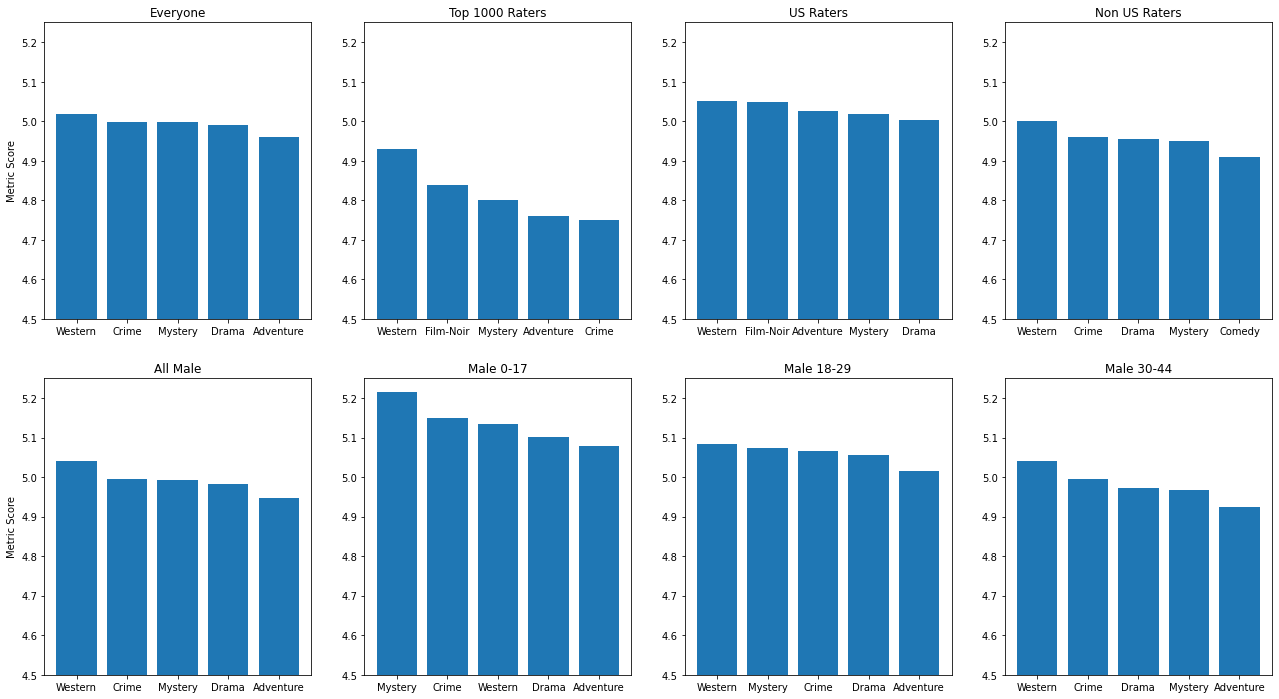

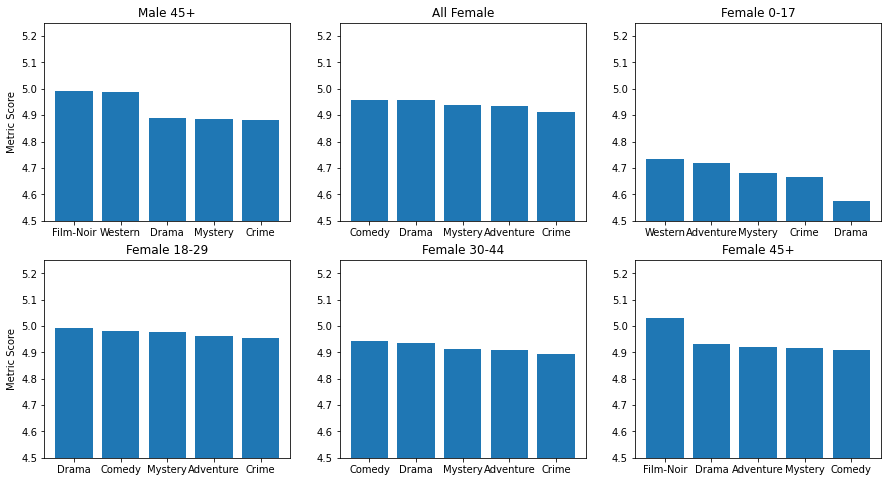

In [43]:
# Plot to show the 5 highest rated genres for each demographic 

fig1, ax1 = plt.subplots(2, 4, figsize = (22,12))
fig2, ax2 = plt.subplots(2, 3, figsize = (15,8))
# everyone 
ax1[0,0].set(title = 'Everyone', ylabel = 'Metric Score')
labels = get_genre_metrics(everyone)[0]
scores = get_arr_scores(everyone)
ax1[0,0].bar(labels, scores)
ax1[0,0].set(ylim = (4.5,5.25))
# top1000 
ax1[0,1].set(title = 'Top 1000 Raters')
labels = get_genre_metrics(top1000raters)[0]
scores = get_arr_scores(top1000raters)
ax1[0,1].bar(labels, scores)
ax1[0,1].set(ylim = (4.5,5.25))
# US 
ax1[0,2].set(title = 'US Raters')
labels = get_genre_metrics(us_raters)[0]
scores = get_arr_scores(us_raters)
ax1[0,2].bar(labels, scores)
ax1[0,2].set(ylim = (4.5,5.25))
# NonUS 
ax1[0,3].set(title = 'Non US Raters')
labels = get_genre_metrics(non_us_raters)[0]
scores = get_arr_scores(non_us_raters)
ax1[0,3].bar(labels, scores)
ax1[0,3].set(ylim = (4.5,5.25))
# All male 
ax1[1,0].set(title = 'All Male', ylabel = 'Metric Score')
labels = get_genre_metrics(male_all)[0]
scores = get_arr_scores(male_all)
ax1[1,0].bar(labels, scores)
ax1[1,0].set(ylim = (4.5,5.25))
# Male 0-17 
ax1[1,1].set(title = 'Male 0-17')
labels = get_genre_metrics(male_017)[0]
scores = get_arr_scores(male_017)
ax1[1,1].bar(labels, scores)
ax1[1,1].set(ylim = (4.5,5.25))
# Male 18-29 
ax1[1,2].set(title = 'Male 18-29')
labels = get_genre_metrics(male_1829)[0]
scores = get_arr_scores(male_1829)
ax1[1,2].bar(labels, scores)
ax1[1,2].set(ylim = (4.5,5.25))
# Male 30-44 
ax1[1,3].set(title = 'Male 30-44')
labels = get_genre_metrics(male_3044)[0]
scores = get_arr_scores(male_3044)
ax1[1,3].bar(labels, scores)
ax1[1,3].set(ylim = (4.5,5.25))
# Male 45+ 
ax2[0,0].set(title = 'Male 45+', ylabel = 'Metric Score')
labels = get_genre_metrics(male45)[0]
scores = get_arr_scores(male45)
ax2[0,0].bar(labels, scores)
ax2[0,0].set(ylim = (4.5,5.25))
# All Female 
ax2[0,1].set(title = 'All Female')
labels = get_genre_metrics(female_all)[0]
scores = get_arr_scores(female_all)
ax2[0,1].bar(labels, scores)
ax2[0,1].set(ylim = (4.5,5.25))
# Female 0-17 
ax2[0,2].set(title = 'Female 0-17')
labels = get_genre_metrics(female_017)[0]
scores = get_arr_scores(female_017)
ax2[0,2].bar(labels, scores)
ax2[0,2].set(ylim = (4.5,5.25))
# Female 18-29 
ax2[1,0].set(title = 'Female 18-29', ylabel = 'Metric Score')
labels = get_genre_metrics(female_1829)[0]
scores = get_arr_scores(female_1829)
ax2[1,0].bar(labels, scores)
ax2[1,0].set(ylim = (4.5,5.25))
# Female 30-44 
ax2[1,1].set(title = 'Female 30-44')
labels = get_genre_metrics(female_3044)[0]
scores = get_arr_scores(female_3044)
ax2[1,1].bar(labels, scores)
ax2[1,1].set(ylim = (4.5,5.25))
# Female 45+ 
ax2[1,2].set(title = 'Female 45+')
labels = get_genre_metrics(female45)[0]
scores = get_arr_scores(female45)
ax2[1,2].bar(labels, scores)
ax2[1,2].set(ylim = (4.5,5.25))

Note: We should be skeptical about the Film-Noir genre since the sample size for those movies is very small 

Question 2: Who are the top directors and what kind of genres have they produced? 

In [44]:
# Let's get the top directors along with the number of times they appear in the top 250 
director_counts = movie_data_orig['Director'].value_counts()

In [45]:
top_5_directors_counts = director_counts[:5].values.tolist()

In [46]:
top_5_directors = director_counts[:5].index.tolist()

In [47]:
# We now need to get the primary genres that make up the movies they directed in the top 250 
def get_genres(director): 
    director_frame = movie_data_orig.loc[movie_data_orig['Director'] == director]
    genre_dict = {}
    for genre in list(director_frame['Primary_Genre']): 
        if genre in genre_dict:
            old_val = genre_dict[genre]
            new_val = old_val + 1
            genre_dict[genre] = new_val
        else: 
            genre_dict[genre] = 1
    return genre_dict 

In [48]:
director_dict = {}
for dir in top_5_directors: 
    director_dict[dir] = get_genres(dir)
all_genres_lists = []
all_genres = []
for dict in list(director_dict.values()): 
    genres = dict.keys()
    all_genres_lists.append(list(genres))
for item in all_genres_lists: 
    for i in range(len(item)): 
        all_genres.append(item[i])
print(np.unique(all_genres))
# These are the genres that we will have to account for in our plot

['Action' 'Adventure' 'Biography' 'Comedy' 'Crime' 'Drama' 'Mystery']


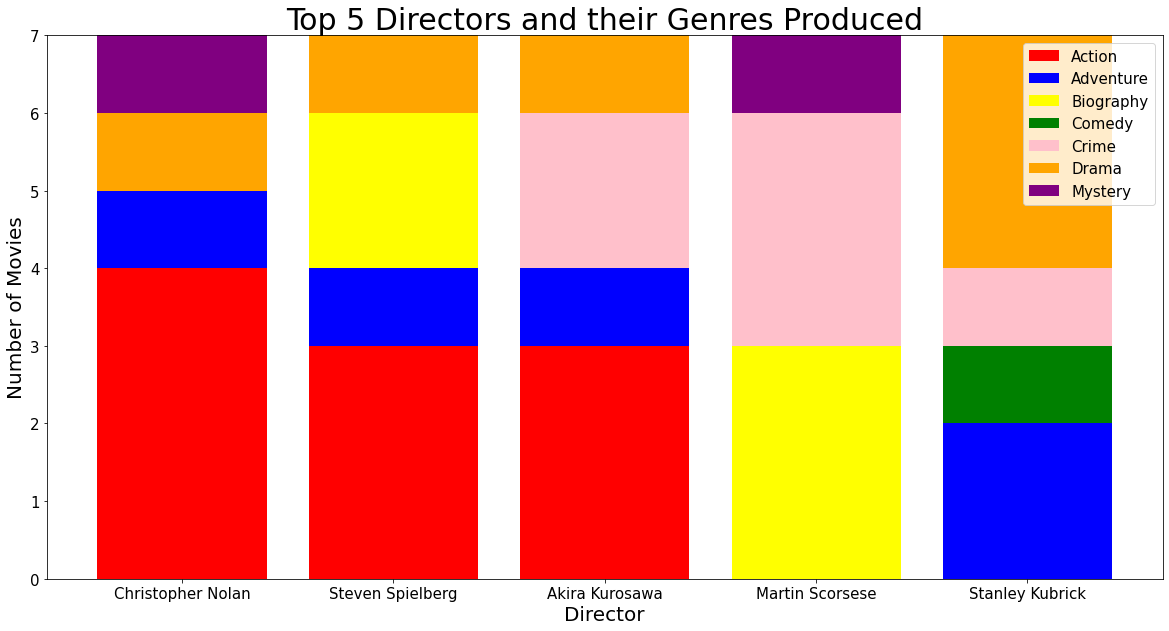

In [179]:
# import needed for list addition below 
from operator import add

action_counts = [0, 0, 0, 0, 0]
adventure_counts = [0, 0, 0, 0, 0]
bio_counts = [0, 0, 0, 0, 0]
comedy_counts = [0, 0, 0, 0, 0]
crime_counts = [0, 0, 0, 0, 0]
drama_counts = [0, 0, 0, 0, 0]
mystery_counts = [0, 0, 0, 0, 0]

for i, director in enumerate(top_5_directors): 
    action_count = get_genres(director).get('Action')
    if action_count != None: 
        action_counts[i] = action_count
    adventure_count = get_genres(director).get('Adventure')
    if adventure_count != None: 
        adventure_counts[i] = adventure_count
    bio_count = get_genres(director).get('Biography')
    if bio_count != None: 
        bio_counts[i] = bio_count
    comedy_count = get_genres(director).get('Comedy')
    if comedy_count != None: 
        comedy_counts[i] = comedy_count
    crime_count = get_genres(director).get('Crime')
    if crime_count != None: 
        crime_counts[i] = crime_count 
    drama_count = get_genres(director).get('Drama')
    if drama_count != None: 
        drama_counts[i] = drama_count 
    mystery_count = get_genres(director).get('Mystery')
    if mystery_count != None: 
        mystery_counts[i] = mystery_count
# Now let's plot the results: 
fig, ax = plt.subplots(1, figsize = (20,10))
plt.title('Top 5 Directors and their Genres Produced', fontsize = 30)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.ylabel('Number of Movies', fontsize = 20)
plt.xlabel('Director', fontsize = 20)
total_counts = [0, 0, 0, 0, 0]
ax.bar(top_5_directors, action_counts, label = 'Action', color = 'red', bottom = total_counts)
total_counts = list(map(add, total_counts, action_counts))
ax.bar(top_5_directors, adventure_counts, label = 'Adventure', color = 'blue', bottom = total_counts)
total_counts = list(map(add, total_counts, adventure_counts))
ax.bar(top_5_directors, bio_counts, label = 'Biography', color = 'yellow', bottom = total_counts)
total_counts = list(map(add, total_counts, bio_counts))
ax.bar(top_5_directors, comedy_counts, label = 'Comedy', color = 'green', bottom = total_counts)
total_counts = list(map(add, total_counts, comedy_counts))
ax.bar(top_5_directors, crime_counts, label = 'Crime', color = 'pink', bottom = total_counts)
total_counts = list(map(add, total_counts, crime_counts))
ax.bar(top_5_directors, drama_counts, label = 'Drama', color = 'orange', bottom = total_counts)
total_counts = list(map(add, total_counts, drama_counts)) 
ax.bar(top_5_directors, mystery_counts, label = 'Mystery', color = 'purple', bottom = total_counts)
ax.legend(prop={'size': 15})

We now can see the makeup of the primary genres that the top 5 directors in the list produced. 

Question 3: Looking at the top 250 movies of all time, were some genres more prevalent in different time periods? (Produce dates) 

In [106]:
# Let's look at the stats of the year column to help us decide on the periods. 
movie_data['Year'] = movie_data['Year'].astype('int64')
movie_data.describe()

,Year
count,4500.000000
mean,1986.460000
std,25.169767
min,1921.000000
25%,1966.000000
50%,1994.000000
75%,2007.000000
max,2022.000000


In [107]:
# Need to create a function to help designate years to time periods,
# Our periods will be 1986-1990, 1991-1996, 1997- 2001, 2002-2006, 2007 - 2012, 2013-2017, 2018-2022
def designate_period(year): 
    if year <= 1990:
        return '1986-1990'
    elif year <= 1996: 
        return '1991-1996'
    elif year <= 2001: 
        return '1997-2001'
    elif year <= 2006: 
        return '2001-2006'
    elif year <= 2012: 
        return '2007-2012'
    elif year <= 2017: 
        return '2013-2017'
    else: 
        return '2018-2022'

In [157]:
# Let's create dictonaries to keep track of the amount of genres in each year 
action_periods = {'1986-1990':0,'1991-1996': 0,'1997-2001':0,'2001-2006':0,'2007-2012':0,'2013-2017':0, '2018-2022':0}
for year in list(movie_data_orig.loc[movie_data_orig['Primary_Genre'] == 'Action', 'Year']): 
    period = designate_period(year)
    old_val = action_periods[period]
    new_val = old_val + 1
    action_periods[period] = new_val
adventure_periods = {'1986-1990':0,'1991-1996': 0,'1997-2001':0,'2001-2006':0,'2007-2012':0,'2013-2017':0, '2018-2022':0}
for year in list(movie_data_orig.loc[movie_data_orig['Primary_Genre'] == 'Adventure', 'Year']): 
    period = designate_period(year)
    old_val = adventure_periods[period]
    new_val = old_val + 1
    adventure_periods[period] = new_val
crime_periods = {'1986-1990':0,'1991-1996': 0,'1997-2001':0,'2001-2006':0,'2007-2012':0,'2013-2017':0, '2018-2022':0}
for year in list(movie_data_orig.loc[movie_data_orig['Primary_Genre'] == 'Crime', 'Year']): 
    period = designate_period(year)
    old_val = crime_periods[period]
    new_val = old_val + 1
    crime_periods[period] = new_val
drama_periods = {'1986-1990':0,'1991-1996': 0,'1997-2001':0,'2001-2006':0,'2007-2012':0,'2013-2017':0, '2018-2022':0}
for year in list(movie_data_orig.loc[movie_data_orig['Primary_Genre'] == 'Drama', 'Year']): 
    period = designate_period(year)
    old_val = drama_periods[period]
    new_val = old_val + 1
    drama_periods[period] = new_val
bio_periods = {'1986-1990':0,'1991-1996': 0,'1997-2001':0,'2001-2006':0,'2007-2012':0,'2013-2017':0, '2018-2022':0}
for year in list(movie_data_orig.loc[movie_data_orig['Primary_Genre'] == 'Biography', 'Year']): 
    period = designate_period(year)
    old_val = bio_periods[period]
    new_val = old_val + 1
    bio_periods[period] = new_val
comedy_periods = {'1986-1990':0,'1991-1996': 0,'1997-2001':0,'2001-2006':0,'2007-2012':0,'2013-2017':0, '2018-2022':0}
for year in list(movie_data_orig.loc[movie_data_orig['Primary_Genre'] == 'Comedy', 'Year']): 
    period = designate_period(year)
    old_val = comedy_periods[period]
    new_val = old_val + 1
    comedy_periods[period] = new_val
animation_periods = {'1986-1990':0,'1991-1996': 0,'1997-2001':0,'2001-2006':0,'2007-2012':0,'2013-2017':0, '2018-2022':0}
for year in list(movie_data_orig.loc[movie_data_orig['Primary_Genre'] == 'Animation', 'Year']): 
    period = designate_period(year)
    old_val = animation_periods[period]
    new_val = old_val + 1
    animation_periods[period] = new_val
horror_periods = {'1986-1990':0,'1991-1996': 0,'1997-2001':0,'2001-2006':0,'2007-2012':0,'2013-2017':0, '2018-2022':0}
for year in list(movie_data_orig.loc[movie_data_orig['Primary_Genre'] == 'Horror', 'Year']): 
    period = designate_period(year)
    old_val = horror_periods[period]
    new_val = old_val + 1
    horror_periods[period] = new_val
western_periods = {'1986-1990':0,'1991-1996': 0,'1997-2001':0,'2001-2006':0,'2007-2012':0,'2013-2017':0, '2018-2022':0}
for year in list(movie_data_orig.loc[movie_data_orig['Primary_Genre'] == 'Western', 'Year']): 
    period = designate_period(year)
    old_val = western_periods[period]
    new_val = old_val + 1
    western_periods[period] = new_val
mystery_periods = {'1986-1990':0,'1991-1996': 0,'1997-2001':0,'2001-2006':0,'2007-2012':0,'2013-2017':0, '2018-2022':0}
for year in list(movie_data_orig.loc[movie_data_orig['Primary_Genre'] == 'Mystery', 'Year']): 
    period = designate_period(year)
    old_val = mystery_periods[period]
    new_val = old_val + 1
    mystery_periods[period] = new_val
noir_periods = {'1986-1990':0,'1991-1996': 0,'1997-2001':0,'2001-2006':0,'2007-2012':0,'2013-2017':0, '2018-2022':0}
for year in list(movie_data_orig.loc[movie_data_orig['Primary_Genre'] == 'Film-Noir', 'Year']): 
    period = designate_period(year)
    old_val = noir_periods[period]
    new_val = old_val + 1
    noir_periods[period] = new_val

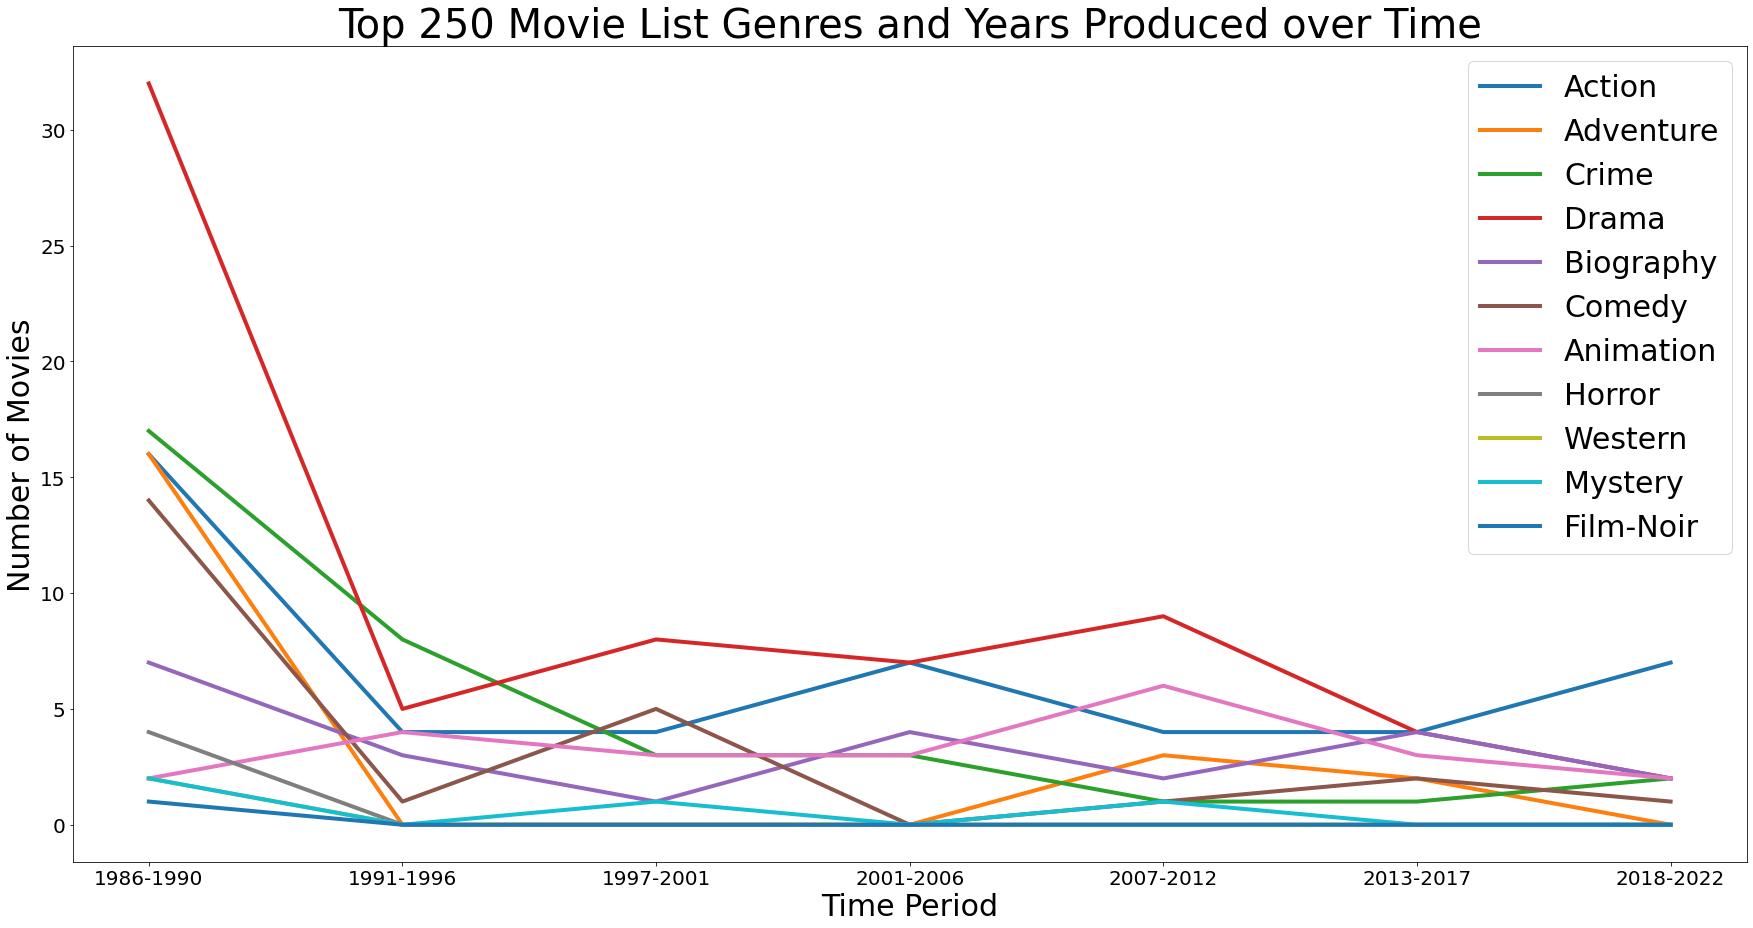

In [171]:
# Now let's plot the results
fig, ax = plt.subplots(1, figsize = (30,15))
plt.ylabel('Number of Movies', fontsize = 30)
plt.xlabel('Time Period', fontsize = 30)
plt.title('Top 250 Movie List Genres and Years Produced over Time', fontsize = 40)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.plot(action_periods.keys(), action_periods.values(), label = 'Action', linewidth = 4)
ax.plot(adventure_periods.keys(), adventure_periods.values(), label = 'Adventure', linewidth = 4)
ax.plot(crime_periods.keys(), crime_periods.values(), label = 'Crime', linewidth = 4)
ax.plot(drama_periods.keys(), drama_periods.values(), label = 'Drama', linewidth = 4)
ax.plot(bio_periods.keys(), bio_periods.values(), label = 'Biography', linewidth = 4)
ax.plot(comedy_periods.keys(), comedy_periods.values(), label = 'Comedy', linewidth = 4)
ax.plot(animation_periods.keys(), animation_periods.values(), label = 'Animation', linewidth = 4)
ax.plot(horror_periods.keys(), horror_periods.values(), label = 'Horror', linewidth = 4)
ax.plot(western_periods.keys(), western_periods.values(), label = 'Western', linewidth = 4)
ax.plot(mystery_periods.keys(), mystery_periods.values(), label = 'Mystery', linewidth = 4)
ax.plot(noir_periods.keys(), noir_periods.values(), label = 'Film-Noir', linewidth = 4)
ax.legend(prop={'size': 30})

# need to add all the same labels to each dict!!